# Using the Elbow method & robustness analysis to explore clustering output


In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *

# Elbow - mean distances
computing the mean distances between all cells and the centroid of the corresponding cluster.

In [114]:
FILTERED_CELLS_PATH = fr'/storage/md_keren/shitay/outputs/variance_filtered/immune_cells_var0.315.pkl'
filtered_cells = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))

In [115]:
scores = []
for K in range(2, 16):
    print(f'K = {K}, ', end='')
    kmeans_clusters_path = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans/kmeans_immune_cells_var0.315_k_{K}.pkl'
    clustering_out = pickle.load(open(kmeans_clusters_path, 'rb'))
    # clusters_indices
    clustering_analysis = pickle.load(open(fr'/storage/md_keren/shitay/outputs/clustering/cluster_analysis/cluster_analysis_21.3.21/cluster_analysis_k_{K}.pkl', 'rb'))


    clustering_out.keys()
    len(clustering_out['clusters'])
    np.array(clustering_out['centers']).shape
    # filtered_cells.counts.shape
    distances = []
    for idx in range(len(clustering_out['clusters'])):
#         print(f'cluster {idx}')
        cluster_indices = clustering_out['clusters'][idx]
        cluster_center = clustering_out['centers'][idx]
        cluster_cells = filtered_cells.counts[cluster_indices]
        cluster_distance = np.min(cdist(cluster_cells, np.expand_dims(cluster_center, axis=0), 'correlation'), axis=1)
#         print(cluster_distance)
        distances.append(cluster_distance.tolist())
    score = np.mean(np.array(flatten_list(distances)))
    print(f'score {score}')
    scores.append(score)


K = 2, score 0.3116550606051973
K = 3, score 0.3049210049758273
K = 4, score 0.3029131073105403
K = 5, score 0.3010566035037296
K = 6, score 0.2945527070065452
K = 7, score 0.2930455970247686
K = 8, score 0.2919037552678174
K = 9, score 0.29213928606700174
K = 10, score 0.28923988431643366
K = 11, score 0.2904070635221433
K = 12, score 0.28949650698279455
K = 13, score 0.2897383604887938
K = 14, score 0.28818278742666875
K = 15, score 0.2893082597430661


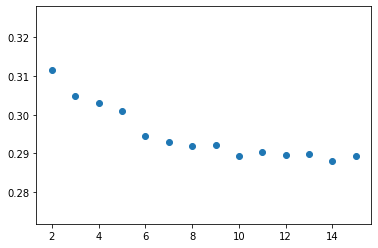

In [116]:
plt.scatter(np.arange(2, 16), scores)

# Elbow - estimating the  variance explained by a given solution 
( Cell, 2018, Figure S8B)
###### OUTPUT WILL BE SAVED IN THE PICKLE FOLDER

computing the sum of pair-wise distances between all cells in different clusters Dis_b=Σl=1-k(Σi∈cl,j∉cl D(i,j)) and the total distance Dis_t= Σi,j D(i,j). The ratio between these two measures V = Dis_b/Dis_t was used to estimate the variance explained by a given solution (Figure S8B), such that in the extreme case where all cells are clustered together or the case where each cell is a single cluster, this ratio would be 0 and 1, respectively. Exploring this ratio, we then select the solutions that are near plateau


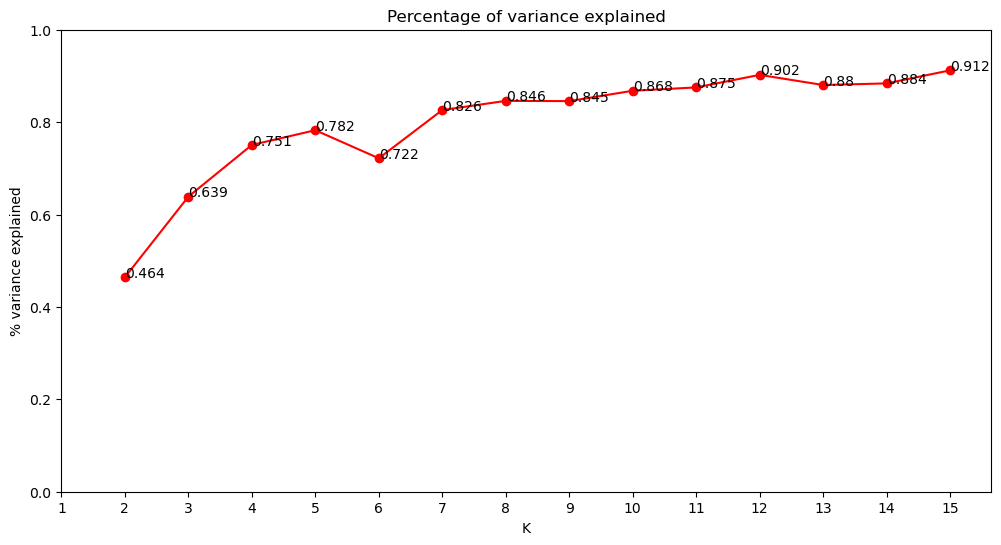

In [3]:
# ELBOW_FOLDER = r'/storage/md_keren/shitay/outputs/clustering/myeloid/elbow/11.8.21'
ELBOW_FOLDER = r'/storage/md_keren/shitay/outputs/clustering/CD8/elbow/subcohort_1.1.22_run_1.1.22'

elbow_pickle_path = join(ELBOW_FOLDER, 'elbow.pkl')

elbow = pickle.load(open(elbow_pickle_path, 'rb'))

All_Dist_b = elbow['Ks_Dist_b']
Dis_t = elbow['Dis_t']

plt.rcdefaults()  # reset params
plt.figure(figsize=(12,6))
distances = [(ii/2)/Dis_t for ii in All_Dist_b.values()]
plt.plot(list(All_Dist_b.keys()), distances, '-or');

plt.ylim((0,1));
distances_dic = dict(zip(list(All_Dist_b.keys()),distances))
for a,b in distances_dic.items(): 
    plt.text(a, b, str(round(b,3)))
plt.title('Percentage of variance explained');
plt.xticks(list(range(1, len(distances)+2,1)));
plt.xlabel('K')
plt.ylabel('% variance explained')


############ SAVE OUTPUT ##########
plt.savefig(join(ELBOW_FOLDER, 'elbow_fig.jpg'))

In [26]:
# dict(zip(list(All_Dist_b.keys()),[(ii/2)/Dis_t for ii in All_Dist_b.values()]))

# Robustness analysis clustering

to determine the robustness of each clustering solution, we need to perform 100 iterations in which we randomly remove 10% of the cells, and re-run the k-means algorithm and check the stability of the clustering solution. We then need to quantify the agreement of a given solution with the original one as the number of pairs of cells that were either clustered together, or not clustered together, in both solutions, divided by the total number pairs shared between the runs.

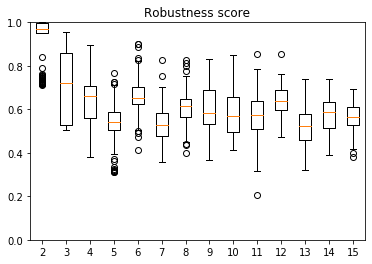

In [121]:
cluster_list = []
median_list = {}
scores = {k: {'number_of_pairs_agreement': [], 
              'number_of_pairs_in_iter_clusters': [],
             'number_of_pairs_in_origin_clusters': []} for k in range(2, 16)}
for k in range(2, 16):
#     print(f'k = ',k)
    count = 0
    for run in range(0, 100):
        file_name = f'K_{k}_run_{run}.txt'        
        if os.path.isfile(join(path, file_name)):
    #         print(run)
            count +=1
            with open(join(path, file_name), "r") as text_file:
                for line in text_file.readlines():
                    line_interpretation = line.replace('\n', '').split(' ')
    #                 scores.append(float(line))
                    scores[k][line_interpretation[0]].append(float(line_interpretation[1]))
#     print('number of runs', count)
    # np.mean(scores)

#     origin_clusters = np.array(scores[k]['number_of_pairs_agreement']) / np.array(scores[k]['number_of_pairs_in_origin_clusters']) 
    iter_clusters = np.array(scores[k]['number_of_pairs_agreement']) / np.array(scores[k]['number_of_pairs_in_iter_clusters'])
#     print('iter clusters median', np.median(iter_clusters))
#     print('origin clusters median', np.median(origin_clusters))
#     cluster_list.append(origin_clusters)
    cluster_list.append(iter_clusters)
    median_list[k] = np.median(iter_clusters)

plt.boxplot(cluster_list, positions=list(range(2,16)));
plt.ylim((0,1));
plt.title('Robustness score');




In [112]:
# list(median_list.keys()) 
sort = np.argsort(np.array(list(median_list.values())))[::-1]
print('Median, highest to lowest:')
for i in sort:
    print('K = %2s'%list(median_list.keys())[i], end=':\t')
    print(list(median_list.values())[i])
# np.array(list(median_list.values()))[sort]

Median, highest to lowest:
K =  2:	0.9694909051732921
K =  3:	0.7216231781513416
K =  4:	0.6598039396512563
K =  6:	0.6531309491405539
K = 12:	0.6361910291721997
K =  8:	0.6136347723170057
K = 14:	0.5888690770600816
K =  9:	0.5838896838642234
K = 11:	0.5744652173201779
K = 10:	0.5713752405140808
K = 15:	0.5625555112267594
K =  5:	0.5425472683164003
K =  7:	0.5300024728467271
K = 13:	0.5241920740371677


# Check which runs are missing and should be run by robustness_analysis_calculation_COMPLETION.py

In [110]:
path = r'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/run_scores/'


path = r'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/run_scores/'
count = {k: [] for k in range(2, 16)}
files = os.listdir(path)
for file in files:
    count[int(file.split('_')[1])].append(int(file.split('_')[3][:-4]))


print()
n_completion = 0
all_renew_runs = []
for k in range(2,16):
    print(f'k = {k}')
#     print(count[i])
    missing = [(k,j) for j in range(100) if not j in count[k]]
    print(f'{len(missing)} files are missing')
    print(missing, end='\n\n')
    n_completion += len(missing)
    
    all_renew_runs += [(k,j) for j in range(100) if not j in count[k]]
    
print(f'\nTotal number of runs missing {n_completion}')
# all_renew_runs ## the list containning all files needed to be added


k = 2
0 files are missing
[]

k = 3
0 files are missing
[]

k = 4
0 files are missing
[]

k = 5
0 files are missing
[]

k = 6
0 files are missing
[]

k = 7
0 files are missing
[]

k = 8
0 files are missing
[]

k = 9
0 files are missing
[]

k = 10
0 files are missing
[]

k = 11
0 files are missing
[]

k = 12
0 files are missing
[]

k = 13
0 files are missing
[]

k = 14
0 files are missing
[]

k = 15
0 files are missing
[]


Total number of runs missing 0


In [12]:
# get number of log file by k and run num
k = 15
run = 20

print('log file num:')
(k - 2) * 100 + run


log file num:


420

# DEBUG

In [183]:
OUTPUT = r'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/run_scores'


In [185]:
result = 0.765
from os.path import join
with open(join(OUTPUT, f't.txt'), "w") as text_file:
    text_file.write(str(result))



In [3]:
K = 3
kmeans_clusters_path = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans/kmeans_immune_cells_var0.315_k_{K}.pkl'
clustering_out = pickle.load(open(kmeans_clusters_path, 'rb'))
clustering_analysis = pickle.load(open(fr'/storage/md_keren/shitay/outputs/clustering/cluster_analysis/cluster_analysis_21.3.21/cluster_analysis_k_{K}.pkl', 'rb'))


In [68]:
# clustering_analysis

In [77]:

# TODO: Understand the problem here. why the correlation of cell with itself doesn't return 0!!!!!!!!
idx = 2
print(cdist(np.expand_dims(cluster_cells[idx], axis=0), np.expand_dims(cluster_cells[idx+1], axis=0), 'correlation'))
# np.expand_dims(cluster_cells[1], axis=1).shape
# user_function(cluster_cells[idx], cluster_cells[idx+1])


print(cdist(cluster_cells[:idx+2], cluster_cells[:idx+2], 'correlation'))

[[0.60175174]]
[[0.00000000e+00 5.72679500e-01 6.33083988e-01 5.66232572e-01]
 [5.72679500e-01 1.11022302e-16 6.31810029e-01 5.76208016e-01]
 [6.33083988e-01 6.31810029e-01 0.00000000e+00 6.01751738e-01]
 [5.66232572e-01 5.76208016e-01 6.01751738e-01 0.00000000e+00]]


In [53]:
arr = np.array([[1,2,3, 4,5, 7, 100, 200]])
# arr = np.array
([[1,2, 3, 100]])
print(cdist(arr, arr, 'correlation'))
user_function(arr[0], arr[0])

[[0.]]


0.0

In [69]:
FILTERED_CELLS_PATH = fr'/storage/md_keren/shitay/outputs/variance_filtered/immune_cells_var0.315.pkl'
filtered_cells = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))

In [70]:
# runs = r'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/runs/'
# for K in os.listdir(runs):
#     k_path = os.path.join(runs, K)
#     for iteration in os.listdir(k_path):
#         pickle.load()
orig = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans/kmeans_immune_cells_var0.315_k_3.pkl', 'rb'))
it = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/runs/3/8.pkl', 'rb'))

In [71]:
n_cells = filtered_cells.number_of_cells
n_cells

89024

In [72]:
mapping_orig_to_filtering  = np.arange(n_cells)[it['sample_indices']]
mapping_orig_to_filtering_dic = {}
for i in range(mapping_orig_to_filtering.shape[0]):
    mapping_orig_to_filtering_dic[mapping_orig_to_filtering[i]] = i 
# print(mapping_dic)

## mapping orig indices to respective indices values after filtering
base_clusters = [[mapping_orig_to_filtering_dic[jj] for jj in ii if jj in mapping_orig_to_filtering_dic.keys()] for ii in orig['clusters']]

iteration_clusters = it['clusters']


In [73]:
filterd_cells = flatten_list(iteration_clusters)
n_cells_filtered = len(filterd_cells)


In [74]:
bool_map = np.zeros((n_cells_filtered, n_cells_filtered))
for cluster in base_clusters:
    for ii in cluster:
        for jj in cluster:
            if ii != jj:
                bool_map[ii, jj] = 1

In [75]:
# bool_map[-10:, :10]

In [76]:
bool_map2 = np.zeros((n_cells_filtered, n_cells_filtered))
for cluster in iteration_clusters:
    for ii in cluster:
        for jj in cluster:
            if ii != jj:
                bool_map2[ii, jj] = 1

In [77]:
re = bool_map + bool_map2 
re2 = re == 2
bw = np.sum(re2) / 2
bw

993290129.0

In [78]:
size = 0
for cluster in base_clusters:
    
    len_cls = len(cluster)
    size += (len_cls * (len_cls-1))/2  
print(size)
bw / size

1246881429.0


0.7966195549135892

In [79]:
size2 = 0
for cluster in iteration_clusters:
    
    len_cls = len(cluster)
    size2 += (len_cls * (len_cls-1))/2  
print(size2)
bw / size2

1879901337.0


0.5283735425100131

In [83]:
print(np.sum(bool_map == 1)/2)
np.sum(bool_map2 == 1)/2

1246881429.0


1879901337.0

In [92]:
dummy = r'/storage/md_keren/shitay/garbage/dummy.txt'
with open(join(dummy), "w") as text_file:
    text_file.write(str(10)+"\n")
    text_file.write('dfdf'+str(4)+"\n")
    text_file.write(str(4)+"\n")

Check whether after filtering 10 percent of the cells the indices are still fitting

In [61]:
k = 4

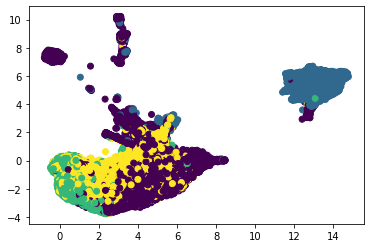

In [62]:
run_path = fr'/storage/md_keren/shitay/outputs/clustering/robustness_analysis_clustering/runs/{k}/10.pkl'

umap_path = r'/storage/md_keren/shitay/outputs/UMAP/UMAP_cohort_immune_o.315var.pkl'

umap_embedded = pickle.load(open(umap_path, 'rb'))
run = pickle.load(open(run_path, 'rb'))

umap_cells = umap_embedded[run['sample_indices']]
# run.
# len(flatten_list(run['clusters']))
colors = np.zeros(umap_cells.shape[0])
for idx, cluster in enumerate(run['clusters']):
    for cell in cluster:
        colors[cell] = idx
plt.pyplot.scatter(umap_cells[:, 0], umap_cells[:, 1], c=colors)

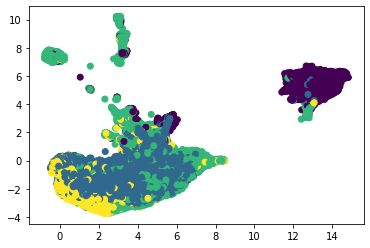

In [63]:
## regular

kmeans_path = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans/kmeans_immune_cells_var0.315_k_{k}.pkl'
umap_cells = umap_embedded[:]
# run.
# len(flatten_list(run['clusters']))
colors = np.zeros(umap_cells.shape[0])
for idx, cluster in enumerate(pickle.load(open(kmeans_path, 'rb'))['clusters']):
    for cell in cluster:
        colors[cell] = idx
plt.pyplot.scatter(umap_cells[:, 0], umap_cells[:, 1], c=colors)